Libraries

In [1]:
# ====================================== Libraries ============================================ #
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

Funções

In [2]:
# ====================================== Functions ============================================ #

# filtrando o dataframe pela coluna DT_COMPTC
def filtring_by_date(dataframe,start_date,end_date=None):
    if end_date is None:
        end_date = datetime.today()
    start_date,end_date =  pd.to_datetime([start_date,end_date]).strftime('%Y-%m-%d')
    filtered_base = dataframe[(dataframe['DT_COMPTC'] >= start_date) & (dataframe['DT_COMPTC'] <= end_date)]
    return filtered_base

# ====================================== Functions ============================================ #

# Função para baixar dados por data e filtrar por data
def download_data(start_date, end_date):

    # transforming str to datetime
    t_start_date = datetime.strptime(start_date, "%Y-%m-%d")
    t_end_date = datetime.strptime(end_date, "%Y-%m-%d")
    list_df = []

    # Lopping between dates
    while t_start_date <= t_end_date:
        
        t_start_year = t_start_date.year
        t_start_month = t_start_date.month

        # importing datas from especific dates
        url = f"https://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/inf_diario_fi_{t_start_year}{t_start_month:02d}.zip"
        df = pd.read_csv(url,sep=';')
        print(f'Files {t_start_year}/{t_start_month:02d} Downloaded')
        list_df.append(df)

        # moving on to the next month
        if t_start_month == 12:
            t_start_year += 1
            t_start_month = 1
        else:
            t_start_month += 1
        
        t_start_date = datetime(t_start_year, t_start_month, 1)

    df_base = pd.concat(list_df)

    base_final = filtring_by_date(df_base,start_date,end_date)

    return base_final

# ====================================== Functions ============================================ #

# adicionando informações adicionais dos fundos
def funds_information(running):
    data_base = pd.read_csv('https://dados.cvm.gov.br/dados/FI/CAD/DADOS/cad_fi.csv',sep=';',encoding='latin-1')

    if not isinstance(running, bool):
        raise TypeError("The paramenter value must be boolean")
    # funds who have worked normally right now
    if running == True:
        data_base = data_base[data_base['SIT']=='EM FUNCIONAMENTO NORMAL']
    if running == False:
        data_base = data_base

    return data_base

# ====================================== Functions ============================================ #

def plot_ax(base_fundo, base_benchmark,bench_name, cnpj, ax):
    fund_to_plot = base_fundo[base_fundo['CNPJ_FUNDO']==cnpj]
    ax.plot(fund_to_plot['DT_COMPTC'],fund_to_plot['RENT_ACUMULADA_2023'],label='Fundo',color='#191970')
    ax.plot(base_benchmark['Data'],base_benchmark['Acumulada'],label=bench_name,color='#6495ED')
    ax.set_ylabel("accumulated Return (%)")
    ax.set_title(base_fundo.loc[base_fundo['CNPJ_FUNDO'] == cnpj, 'DENOM_SOCIAL'].values[0],fontsize=10)
    ax.grid(True,linestyle='-',linewidth='0.5')


# ====================================== Functions ============================================ #


def plot_ax_low(base_fundo, base_benchmark_1,base_benchmark_2, cnpj, ax):
    fund_to_plot = base_fundo[base_fundo['CNPJ_FUNDO']==cnpj]
    ax.plot(fund_to_plot['DT_COMPTC'],fund_to_plot['RENT_ACUMULADA_2023'],label='Fundo',color='#191970')
    ax.plot(base_benchmark_1['Data'],base_benchmark_1['Acumulada'],label='CDI',color='#6495ED')
    ax.plot(base_benchmark_2['Data'],base_benchmark_2['Acumulada'],label='IBOV',color='#8c93ae')

    #ax.set_ylabel("accumulated Return (%)")
    ax.set_title(base_fundo.loc[base_fundo['CNPJ_FUNDO'] == cnpj, 'DENOM_SOCIAL'].values[0],fontsize=10)
    ax.grid(True,linestyle='-',linewidth='0.5')

"BACK-END/CODE" for helping to analysis

In [3]:
# ====================================== BACK END - DOWNLOADING NECESSARY FILES ============================================ #

# Downloading files

start_date = '2022-12-30'
end_date = '2023-12-29'

data_base = download_data(start_date,end_date)

funds_infos = funds_information(running=True)[['CNPJ_FUNDO','DENOM_SOCIAL','CLASSE','ADMIN','GESTOR']]

Files 2022/12 Downloaded
Files 2023/01 Downloaded
Files 2023/02 Downloaded
Files 2023/03 Downloaded
Files 2023/04 Downloaded
Files 2023/05 Downloaded
Files 2023/06 Downloaded
Files 2023/07 Downloaded
Files 2023/08 Downloaded
Files 2023/09 Downloaded
Files 2023/10 Downloaded
Files 2023/11 Downloaded
Files 2023/12 Downloaded


Let's see which funds had the best and the worst returns in 2023

In [4]:
# ====================================== DATA HANDLE ============================================ #

# merging the both dataframes but only funds wich are in both data base
df_winfs = pd.merge(data_base,funds_infos,on='CNPJ_FUNDO',how='inner')
df_winfs['GESTOR'] = df_winfs['GESTOR'].replace(['CREDIT SUISSE HEDGING-GRIFFO WEALTH MANAGEMENT S.A.','CREDIT SUISSE (BRASIL) S/A CTVM'], 'CREDIT SUISSE')


# filtring Credit Suisse managed
l_calc_memory = []
cs_funds = df_winfs[df_winfs['GESTOR'].isin(['CREDIT SUISSE'])]

# calculating information to analysis
for cnpj in cs_funds['CNPJ_FUNDO'].unique():
    fund = cs_funds[cs_funds['CNPJ_FUNDO']==cnpj]
    
    # making sure all the funds are sorted by descending data
    fund = fund.sort_values('DT_COMPTC',ascending=True).reset_index().drop('index',axis=1)

    # Daily NET
    fund['NET_DAY'] = fund['CAPTC_DIA'] - fund['RESG_DIA']
    
    # Daily profitability
    fund['RENT_DIA'] = 0
    fund['RENT_DIA'] = fund['VL_QUOTA']/fund['VL_QUOTA'].shift()-1
    fund.loc[fund.index[0], 'RENT_DIA'] = 0


    # Accumulated Profitability
    fund['RENT_ACUMULADA_2023'] = 0
    fund['RENT_ACUMULADA_2023'] = ((1 + fund['RENT_DIA'].iloc[1:]).cumprod() - 1)*100
    fund.loc[fund.index[0], 'RENT_ACUMULADA_2023'] = 0



    l_calc_memory.append(fund)
    
cs_funds_consolided = pd.concat(l_calc_memory)
cs_funds_consolided['DT_COMPTC'] = pd.to_datetime(cs_funds_consolided['DT_COMPTC'])

# mask - Last rows/date of each date containing final profitability
last_rows = cs_funds_consolided.groupby('CNPJ_FUNDO')['DT_COMPTC'].max()

# filtring the data base consolided according to the mask
cs_higher_and_lower_return = cs_funds_consolided[cs_funds_consolided['DT_COMPTC'].isin(last_rows)]

cs_higher_and_lower_return_cleaned = cs_higher_and_lower_return[['CNPJ_FUNDO','DENOM_SOCIAL','TP_FUNDO','CLASSE','RENT_ACUMULADA_2023']]

# top 5 higher (and outliners) and lower profitability
# I removed the first one outliner from the dataframe top5_higher_outliner, because that one is not an actively managed fund from the credit suisse manager, but rather a mandate with another house
top5_higher_outliner = cs_higher_and_lower_return_cleaned.sort_values(by='RENT_ACUMULADA_2023',ascending=False).reset_index().drop('index',axis=1).head(2).drop(0)
top5_higher_return = cs_higher_and_lower_return_cleaned.sort_values(by='RENT_ACUMULADA_2023',ascending=False).reset_index().drop('index',axis=1).iloc[2:7,:].reset_index().drop('index',axis=1)
top5_lower_return = cs_higher_and_lower_return_cleaned.sort_values(by='RENT_ACUMULADA_2023',ascending=True).reset_index().drop('index',axis=1).head(5)

display(top5_higher_outliner)
display(top5_higher_return)
display(top5_lower_return)


,CNPJ_FUNDO,DENOM_SOCIAL,TP_FUNDO,CLASSE,RENT_ACUMULADA_2023
1,40.914.546/0001-72,CS CERES I DEB NORTE FUNDO DE INVESTIMENTO MUL...,FI,Fundo Multimercado,309.287025


,CNPJ_FUNDO,DENOM_SOCIAL,TP_FUNDO,CLASSE,RENT_ACUMULADA_2023
0,03.920.198/0001-10,CSHG FMP - FGTS PETROBRAS,FI,FMP-FGTS,66.885310
1,16.671.782/0001-20,CSHG EAST FUNDO DE INVESTIMENTO MULTIMERCADO -...,FI,Fundo Multimercado,59.035280
2,42.904.928/0001-40,CSHG ALLOCATION TB CAPITAL FUNDO DE INVESTIMEN...,FI,Fundo de Ações,50.018211
3,32.708.233/0001-30,CSHG INFLATION 2035 FUNDO DE INVESTIMENTO MULT...,FI,Fundo Multimercado,37.880368
4,31.525.127/0001-58,CSHG IDKA 3 3X FUNDO DE INVESTIMENTO MULTIMERCADO,FI,Fundo Multimercado,35.774598


,CNPJ_FUNDO,DENOM_SOCIAL,TP_FUNDO,CLASSE,RENT_ACUMULADA_2023
0,38.903.455/0001-90,CSHG SIRIUS FUNDO DE INVESTIMENTO FINANCEIRO -...,FI,Fundo Multimercado,-99.938195
1,16.929.533/0001-92,CSHG TS FUNDO DE INVESTIMENTO MULTIMERCADO,FI,Fundo Multimercado,-77.618904
2,08.721.129/0001-09,CSHG LONDON FUNDO DE INVESTIMENTO MULTIMERCADO...,FI,Fundo Multimercado,-67.842329
3,20.403.355/0001-39,CSHG EUROPEAN PROPERTY FEEDER FUNDO DE INVESTI...,FI,Fundo Multimercado,-55.947666
4,14.549.719/0001-90,CSHG ALMAVIVA FUNDO DE INVESTIMENTO MULTIMERCA...,FI,Fundo Multimercado,-50.897062


Now let's plot the graph to better visualize the profitability of these funds

In [5]:
# ====================================== BENCHMARKS BASE ACUMULLATED ============================================ #

cdi_base = pd.read_excel('CDI.xlsx')
cdi_base = cdi_base[cdi_base['Data']>='2022-12-30']

# fixing non formated datas of column 'Fator Di-rio'
cdi_base['Rent_diaria'] = (cdi_base['Fator Di·rio']/100000000)-1

# calculating accumulated retun in 2023
cdi_base['Acumulada'] = ((1 + cdi_base['Rent_diaria'].iloc[1:]).cumprod() - 1)*100
cdi= cdi_base[['Data','Acumulada']].reset_index().drop('index',axis=1).drop(0).reset_index().drop('index',axis=1)

# ibov
# Applying the same logic to IBOV INDEX
ibov_base = pd.read_csv('ibovespa.csv')
ibov_base['Data'] = pd.to_datetime(ibov_base['DATA'], format='%d/%m/%Y')
ibov_base = ibov_base.sort_values(by='Data')
ibov_base['RENT_DIARIA'] = (ibov_base['FECHAMENTO']/ibov_base['FECHAMENTO'].shift(1))-1
ibov_base['Acumulada'] = ((1 + ibov_base['RENT_DIARIA'].iloc[1:]).cumprod() - 1)*100
ibov = ibov_base[['Data','Acumulada']].reset_index().drop('index',axis=1).drop(0).reset_index().drop('index',axis=1)

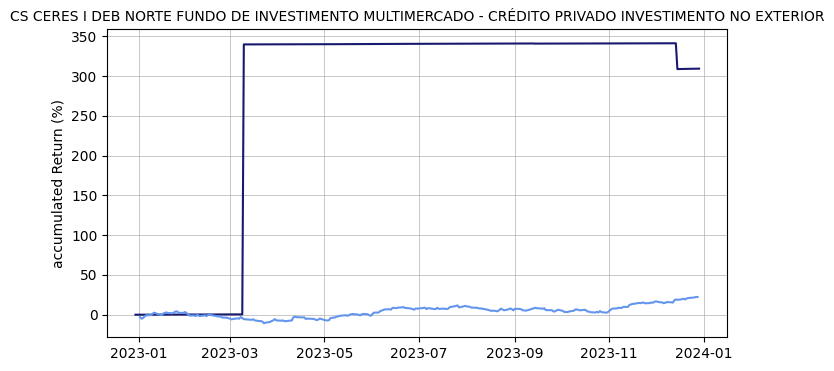

In [6]:
# ====================================== OUTLINER RETURN ============================================ #

fig,ax = plt.subplots(figsize=(8,4))
plot_ax(cs_funds_consolided,ibov,'IBOV','40.914.546/0001-72',ax)
plt.show()

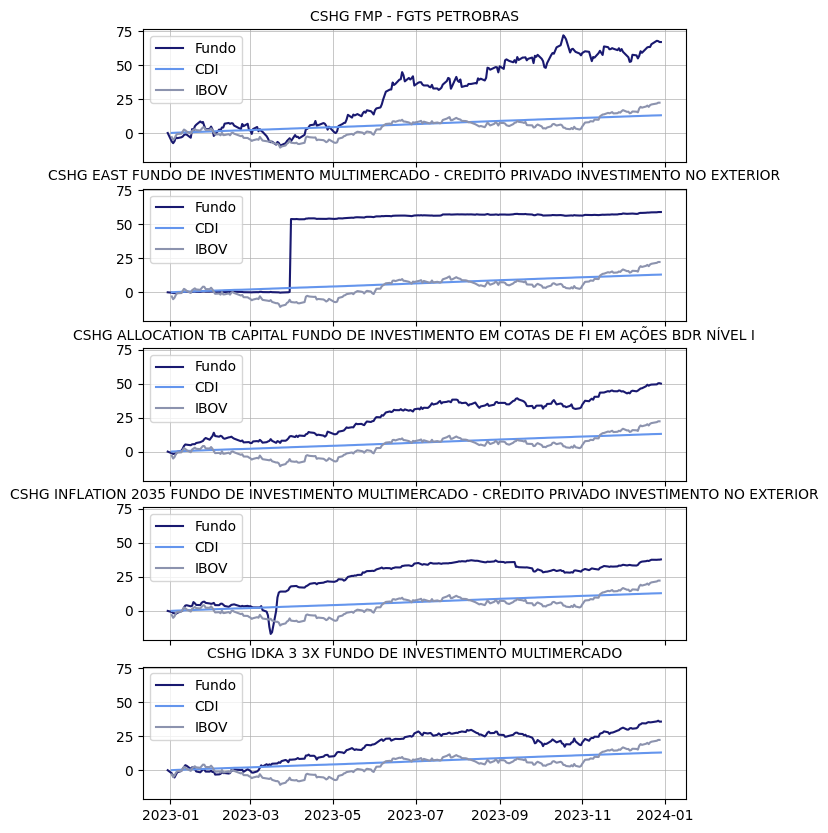

In [7]:
# ====================================== TOP 5 BEST RETURNS ============================================ #

fig, axs = plt.subplots(5,1,figsize=(7,10),sharey='all',sharex='all')

# Use a função plot_ax diretamente no objeto do subplot

plot_ax_low(cs_funds_consolided,cdi,ibov,'03.920.198/0001-10',axs[0])
plot_ax_low(cs_funds_consolided,cdi,ibov,'16.671.782/0001-20',axs[1])
plot_ax_low(cs_funds_consolided,cdi,ibov,'42.904.928/0001-40',axs[2])
plot_ax_low(cs_funds_consolided,cdi,ibov,'32.708.233/0001-30',axs[3])
plot_ax_low(cs_funds_consolided,cdi,ibov,'31.525.127/0001-58',axs[4])





for ax in axs:
    ax.legend(loc='upper left')

plt.show()


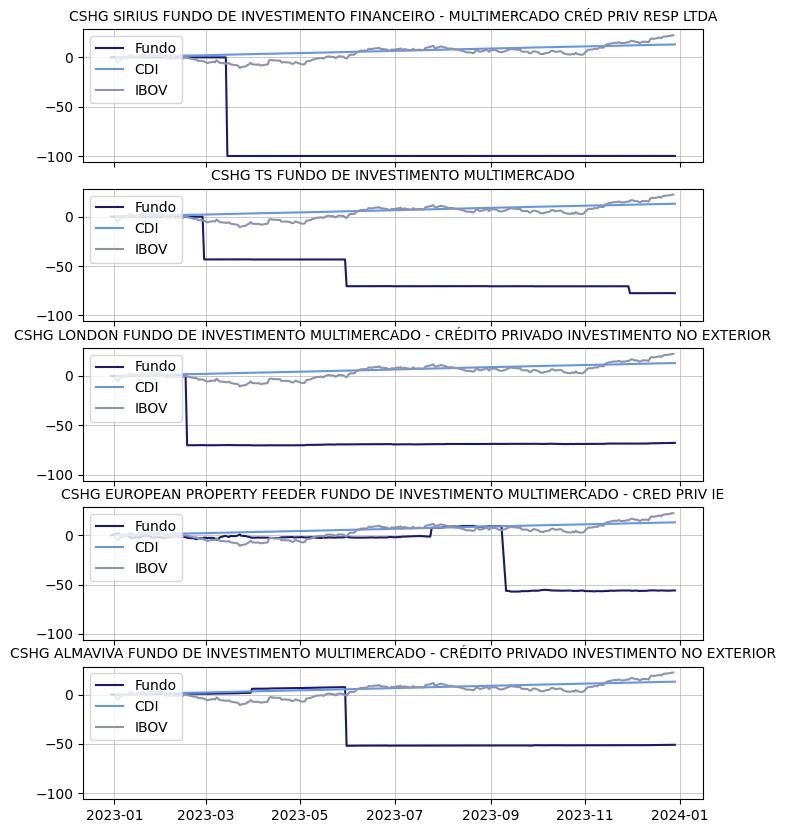

In [8]:
# ===== TOP 5 LOWERS RETURN =====
fig,axs = plt.subplots(5,1,figsize=(8,10),sharey='all',sharex='all')

plot_ax_low(cs_funds_consolided,cdi,ibov,'38.903.455/0001-90',axs[0])
plot_ax_low(cs_funds_consolided,cdi,ibov,'16.929.533/0001-92',axs[1])
plot_ax_low(cs_funds_consolided,cdi,ibov,'08.721.129/0001-09',axs[2])
plot_ax_low(cs_funds_consolided,cdi,ibov,'20.403.355/0001-39',axs[3])	
plot_ax_low(cs_funds_consolided,cdi,ibov,'14.549.719/0001-90',axs[4])

for ax in axs:
    ax.legend(loc='upper left')
    
plt.show()

As we can see, all of the top 5 lowest returns are private credit funds. This could be due to the periodic amortization of assets. When this occurs, the fund's assets decrease, leading to a reduction in the value of the shares.

However, this doesn't necessarily imply the fund's profitability decreases in line with the asset. The assets continue giving returns in the same way.

It could be easiy fixed using a "fake cota" based on the math formula => 

Return/profitability on D-0 after redemptions or amortization  (((NAV + redemptions paid/amortization)/number of shareholders)/Quota price on D-1)

Now we understand what's happening with the charts, let's remove the searches with 'Credito Privado' in the name to try to identify something more indicative of a true negative profitability.

## IMPORTANT ## 

the fund CSHG TS FUNDO DE INVESTIMENTO MULTIMERCADO sounds like a fund going to be liquited. In this clase, the same quota event that happens with credit private funds, can happen with no credit private funds

,CNPJ_FUNDO,DENOM_SOCIAL,TP_FUNDO,CLASSE,RENT_ACUMULADA_2023
0,16.929.533/0001-92,CSHG TS FUNDO DE INVESTIMENTO MULTIMERCADO,FI,Fundo Multimercado,-77.618904
1,01.464.595/0001-07,CSHG FUNDO DE INVESTIMENTO CAMBIAL,FI,Fundo Cambial,-2.464164
2,42.904.972/0001-50,CSHG EB TRANSIÇÃO ENERGÉTICA FUNDO DE INVESTIM...,FI,Fundo Multimercado,-2.261008
3,36.874.628/0001-63,CSHG ALL SPX NIMITZ FUNDO DE INVESTIMENTO EM C...,FI,Fundo Multimercado,-1.469596
4,42.903.657/0001-09,CSHG ALLOCATION VINLAND MACRO PLUS FUNDO DE IN...,FI,Fundo Multimercado,-0.926918


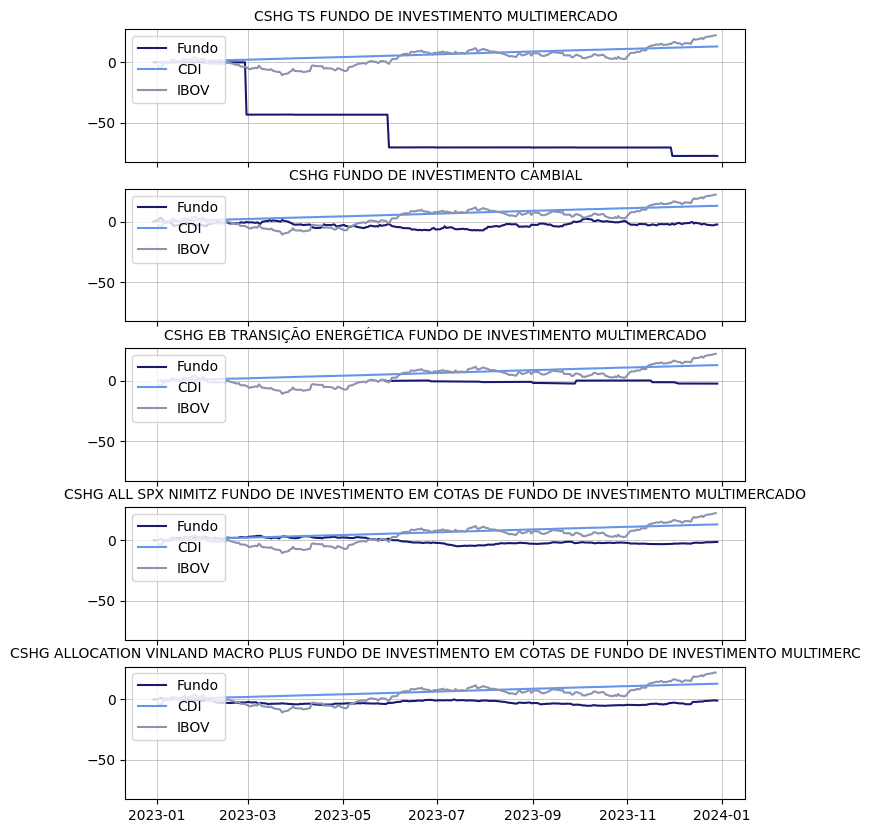

In [9]:
# ====================================== TOP 5 WORST RETURNS - NO PRIVATE CREDIT ============================================ #


# Filtring funds without words such as cred | priv | créd | cp

mask_no_cp = ~cs_funds_consolided['DENOM_SOCIAL'].str.contains('cred|priv|créd|cp',regex=True,case=False)
cs_funds_consolided_no_cp = cs_funds_consolided[mask_no_cp]
cs_no_cp = cs_funds_consolided_no_cp[cs_funds_consolided_no_cp['DT_COMPTC'].isin(last_rows)][['CNPJ_FUNDO','DENOM_SOCIAL','TP_FUNDO','CLASSE','RENT_ACUMULADA_2023']]

top5_nocp_lower_return = cs_no_cp.sort_values(by='RENT_ACUMULADA_2023',ascending=True).reset_index().drop('index',axis=1).head(5)


# top 5 lowers returns
fig,axs = plt.subplots(5,1,figsize=(8,10),sharey='all',sharex='all')

plot_ax_low(cs_funds_consolided_no_cp,cdi,ibov,'16.929.533/0001-92',axs[0])
plot_ax_low(cs_funds_consolided_no_cp,cdi,ibov,'01.464.595/0001-07',axs[1])
plot_ax_low(cs_funds_consolided_no_cp,cdi,ibov,'42.904.972/0001-50',axs[2])
plot_ax_low(cs_funds_consolided_no_cp,cdi,ibov,'36.874.628/0001-63',axs[3])	
plot_ax_low(cs_funds_consolided_no_cp,cdi,ibov,'42.903.657/0001-09',axs[4])

display(top5_nocp_lower_return)


for ax in axs:
    ax.legend(loc='upper left')
plt.show()

Now, let's investigate the net assets of all funds managed by the asset manager and how credit suisse are positioned in the nacional market

In [10]:
# maiores gestores

last_day_year = df_winfs[df_winfs['DT_COMPTC']=='2023-12-29']
last_day_year = last_day_year.rename(columns={'VL_PATRIM_LIQ':'TOTAL_MARKET'})

# agrupado por gestor
gruped_funds_gestor = last_day_year[['GESTOR','TOTAL_MARKET']].groupby(by=['GESTOR']).sum().sort_values('TOTAL_MARKET',ascending=True).reset_index()
class_cs = gruped_funds_gestor[gruped_funds_gestor['GESTOR']=='CREDIT SUISSE']
class_cs['TOTAL_MARKET'] = class_cs['TOTAL_MARKET'].map('{:,.2f}'.format)


# agrupado por classe
gruped_funds_classe = last_day_year[['CLASSE','TOTAL_MARKET']].groupby(by=['CLASSE']).sum().sort_values('TOTAL_MARKET',ascending=True).reset_index()


# preparando bases
cs_base_fundos = cs_higher_and_lower_return[['CLASSE','VL_PATRIM_LIQ']].groupby(by=['CLASSE']).sum().reset_index()
cs_base_fundos = cs_base_fundos.rename(columns={"VL_PATRIM_LIQ":"CREDIT'S ASSETS"})
comparativo_classe = gruped_funds_classe.set_index('CLASSE').join(cs_base_fundos.set_index('CLASSE')).reset_index()
comparativo_classe['% CREDIT OF TOTAL'] = (comparativo_classe["CREDIT'S ASSETS"]/comparativo_classe['TOTAL_MARKET'])*100
comparativo_classe['CLASSE'] = comparativo_classe['CLASSE'].str.replace('Fundo ','').str.replace('de ','')


all_pl = comparativo_classe['TOTAL_MARKET'].sum()
cs_pl = comparativo_classe["CREDIT'S ASSETS"].sum()

comparativo_classe.fillna(0,inplace=True)

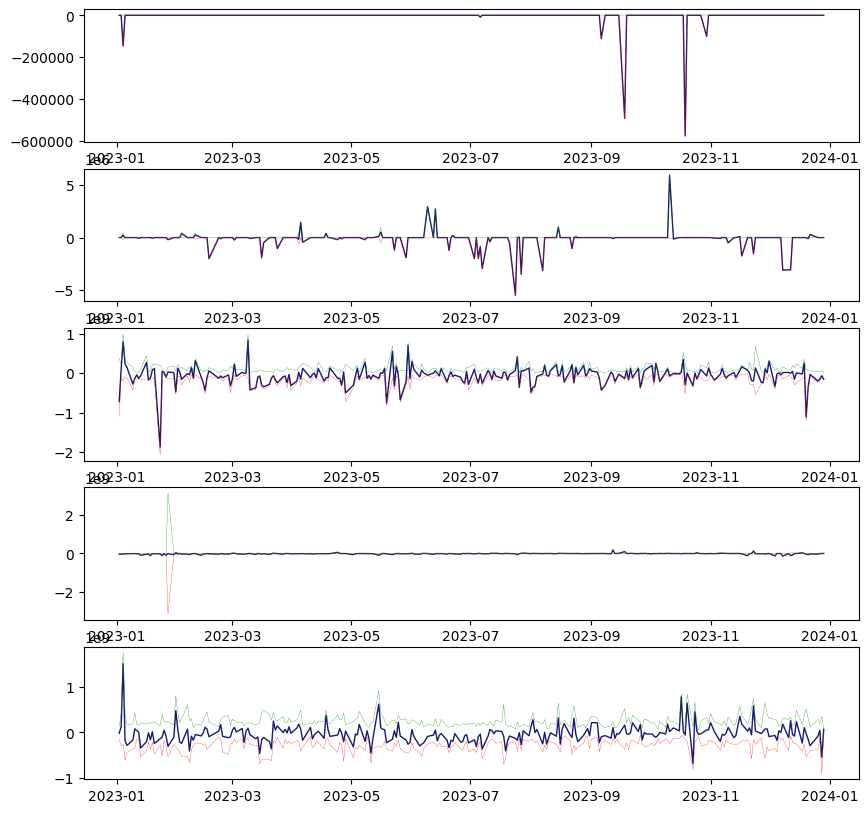

In [11]:
# NET per class

net_base = cs_funds_consolided[cs_funds_consolided['DT_COMPTC']>='2023-01-01']
net_base_cleaned = net_base[['DT_COMPTC','CAPTC_DIA','RESG_DIA','CLASSE']]

net_base_cleaned['RESG_DIA'] = net_base_cleaned['RESG_DIA']*-1

net_base_cleaned = net_base_cleaned.groupby(by=['DT_COMPTC','CLASSE']).sum().reset_index()

net_base_cleaned['CLASSE'] = net_base_cleaned['CLASSE'].str.replace('Fundo ','').str.replace('de ','')
net_base_cleaned['NET_DIA']= net_base_cleaned['CAPTC_DIA'] + net_base_cleaned['RESG_DIA']


fig,ax = plt.subplots(5,1,figsize=(10,10))
i = 0
for classe in net_base_cleaned['CLASSE'].unique():

    classes_dfs = net_base_cleaned[net_base_cleaned['CLASSE']==classe]

    ax[i].plot(classes_dfs['DT_COMPTC'],classes_dfs['NET_DIA'],linewidth=1,color = '#191970')
    ax[i].plot(classes_dfs['DT_COMPTC'],classes_dfs['CAPTC_DIA'],linewidth=0.2,color='green')
    ax[i].plot(classes_dfs['DT_COMPTC'],classes_dfs['RESG_DIA'],linewidth=0.2,color='red')

    i += 1

plt.show()

,CLASSE,TOTAL_MARKET,CREDIT'S ASSETS,% CREDIT OF TOTAL
0,FIP Multi,1.829495e+08,0.000000e+00,0.000000
1,FIDC,1.987103e+08,0.000000e+00,0.000000
2,FIDC-NP,5.360799e+08,0.000000e+00,0.000000
3,FIC FIDC,6.225774e+08,0.000000e+00,0.000000
5,FIP,1.041143e+10,0.000000e+00,0.000000
6,FMP-FGTS,1.353999e+10,1.475416e+07,0.108967
4,Cambial,1.003026e+10,1.520423e+07,0.151584
7,Ações,8.856812e+11,1.504514e+10,1.698709
9,Renda Fixa,7.414813e+12,1.960925e+10,0.264460
8,Multimercado,3.229833e+12,7.228866e+10,2.238155


,GESTOR,TOTAL_MARKET
928,CREDIT SUISSE,"106,973,013,369.61"


fund market assets at 29/12/2023: R$ 11,565,849,911,593.29
credit's fund asset at 29/12/2023: R$ 106,973,013,369.61


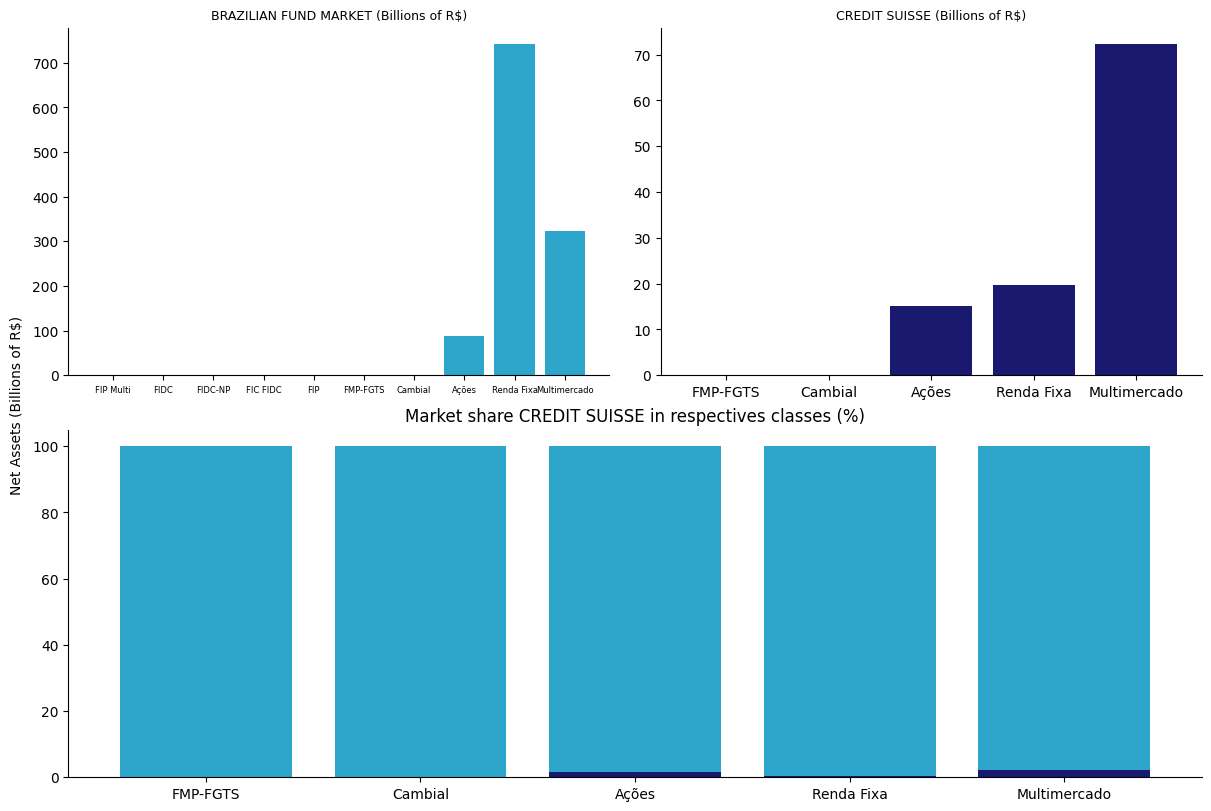

In [12]:
# ASSETS UNDER MANAGMENT BRAZIL X CREDIT SUISSE

comparativo_classe=comparativo_classe.sort_values(by="CREDIT'S ASSETS")

y_tm = comparativo_classe['TOTAL_MARKET']/10000000000
x_tm = comparativo_classe['CLASSE']

y_cs = comparativo_classe[comparativo_classe["CREDIT'S ASSETS"]!=0]["CREDIT'S ASSETS"]/1000000000
x_cs = comparativo_classe[comparativo_classe["CREDIT'S ASSETS"]!=0]["CLASSE"]


fig, ax = plt.subplot_mosaic([['upleft', 'upright'],
                               ['low', 'low']], layout='constrained',figsize=(12,8))


ax['upleft'].bar(x_tm,y_tm,color='#2ea6cb')#,order=ordem)
ax['upleft'].set_title("BRAZILIAN FUND MARKET (Billions of R$)",fontsize=9)
ax['upleft'].set_xticks(x_tm)
ax['upleft'].set_xticklabels(x_tm, fontsize=6)
ax['upleft'].spines['top'].set_visible(False)    
ax['upleft'].spines['right'].set_visible(False)


# ax 1 -- CREDIT SUISSE HEDGING-GRIFFO WEALTH MANAGEMENT S.A.
ax['upright'].bar(x_cs,y_cs,color='#191970')
ax['upright'].set_title("CREDIT SUISSE (Billions of R$)",fontsize=9)
ax['upright'].set_xticks(x_cs)
ax['upright'].spines['top'].set_visible(False)    
ax['upright'].spines['right'].set_visible(False)


ax['low'].bar(comparativo_classe[comparativo_classe["CREDIT'S ASSETS"]!=0]["CLASSE"],100,color='#2ea6cb')
ax['low'].bar(x_cs,comparativo_classe[comparativo_classe["CREDIT'S ASSETS"]!=0]["% CREDIT OF TOTAL"],color='#191970')
ax['low'].set_title("Market share CREDIT SUISSE in respectives classes (%)")
ax['low'].spines['top'].set_visible(False)    
ax['low'].spines['right'].set_visible(False)



display(comparativo_classe)
display(class_cs)


print(f"fund market assets at 29/12/2023: R$ {all_pl:,.2f}")
print(f"credit's fund asset at 29/12/2023: R$ {cs_pl:,.2f}")

## fig
fig.supylabel("Net Assets (Billions of R$)",fontsize=10)

## plt
plt.subplots_adjust(left=0.08)
plt.show()